# Notebook for running AORC forcings with BMI LSTM

Steps to prep before this notebook:

1. `git clone`
2. `pip install -r requirements.txt`
3. `pip install .`

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from lstm import bmi_lstm  # Load module bmi_lstm (bmi_lstm.py) from lstm package.

### Change the rundir to be your local dir

In [2]:
import yaml
run_dir = Path.cwd().parent / "trained_neuralhydrology_models/hourly_aorc"
lstm_config_path = "/projects/mhpi/tbindas/lstm/trained_neuralhydrology_models/hourly_aorc/config.yml"
with open(lstm_config_path, "r") as f:
    lstm_config = yaml.safe_load(f)
    
lstm_config["run_dir"] = run_dir.__str__()

with open(lstm_config_path, "w") as f:
    yaml.safe_dump(lstm_config, f)

In [3]:
# Define primary bmi config and input data file paths 
#bmi_cfg_file=Path('./bmi_config_files/01022500_hourly_all_attributes_forcings.yml')
USE_PATH = True
run_dir = Path.cwd().parent

basin_num = '05057200'
# bmi_cfg_file  = run_dir  / 'bmi_config_files/01022500_hourly_slope_mean_precip_temp.yml'
bmi_cfg_file  = run_dir  / f'bmi_config_files/{basin_num}_hourly_aorc.yml'
# sample_data_file = run_dir + 'data/usgs-streamflow-nldas_hourly.nc'
sample_data_file = run_dir / f'data/aorc_hourly/{basin_num}_1980_to_2024_agg_rounded.csv'

# creating an instance of an LSTM model
print('Creating an instance of an BMI_LSTM model object')
model = bmi_lstm.bmi_LSTM()

# Initializing the BMI
print('Initializing the BMI')
model.initialize(bmi_cfg_file)

# Get input data that matches the LSTM test runs
print('Gathering input data')
# sample_data = Dataset(sample_data_file, 'r')
sample_data = pd.read_csv(sample_data_file)

Creating an instance of an BMI_LSTM model object
Initializing the BMI
Initializing all forcings to 0...
  forcing_name = APCP_surface
  forcing_name = TMP_2maboveground
  forcing_name = DLWRF_surface
  forcing_name = DSWRF_surface
  forcing_name = PRES_surface
  forcing_name = SPFH_2maboveground
  forcing_name = UGRD_10maboveground
  forcing_name = VGRD_10maboveground
Gathering input data


/home/tbindas/tbindas/.conda/envs/lstm_/lib/python3.10/site-packages/lstm/bmi_lstm.py:267: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_state_dict = torch.load(trai

In [4]:
obs_df = pd.read_csv(f'../data/{basin_num}-usgs-hourly.csv')
start_time = pd.to_datetime(obs_df["date"][0])
sample_data = sample_data[(pd.to_datetime(sample_data['time']) >= start_time)]
sample_data.head()

,time,APCP_surface,DLWRF_surface,DSWRF_surface,PRES_surface,SPFH_2maboveground,TMP_2maboveground,UGRD_10maboveground,VGRD_10maboveground
8813,1994-10-01 05:00:00,0.0,324.8,0.0,96300.0,0.0049,277.7,-2.2,-3.0
8814,1994-10-01 06:00:00,0.0,293.0,0.0,96300.0,0.0049,277.7,-2.1,-2.0
8815,1994-10-01 07:00:00,0.0,291.9,0.0,96340.0,0.0047,277.0,-1.9,-1.7
8816,1994-10-01 08:00:00,0.0,291.0,0.0,96370.0,0.0046,276.4,-1.7,-1.5
8817,1994-10-01 09:00:00,0.0,274.7,0.0,96390.0,0.0044,275.8,-1.5,-1.2


In [5]:
total_iterations = len(sample_data['DLWRF_surface'].values)
runoff_output = np.ones_like(sample_data['DLWRF_surface'].values)
print('Set values & update model for number of timesteps = 100')
for i, (precip, temp, DLWRF, DSWRF, PRES, SPFH, UGRD, VGRD) in tqdm(
    enumerate(zip(
        list(sample_data['APCP_surface'].values),
        list(sample_data['TMP_2maboveground'].values),
        list(sample_data['DLWRF_surface'].values),
        list(sample_data['DSWRF_surface'].values),
        list(sample_data['PRES_surface'].values),
        list(sample_data['SPFH_2maboveground'].values),
        list(sample_data['UGRD_10maboveground'].values),
        list(sample_data['VGRD_10maboveground'].values)
    )),
    total=total_iterations,
    desc="Processing LSTM times"
):
    model.set_value('atmosphere_water__liquid_equivalent_precipitation_rate',np.atleast_1d(precip))
    model.set_value('land_surface_air__temperature',np.atleast_1d(temp))
    model.set_value('land_surface_radiation~incoming~longwave__energy_flux',np.atleast_1d(DLWRF))
    model.set_value('land_surface_radiation~incoming~shortwave__energy_flux',np.atleast_1d(DSWRF))
    model.set_value('land_surface_air__pressure',np.atleast_1d(PRES))
    model.set_value('atmosphere_air_water~vapor__relative_saturation',np.atleast_1d(SPFH))
    model.set_value('land_surface_wind__x_component_of_velocity',np.atleast_1d(UGRD))
    model.set_value('land_surface_wind__y_component_of_velocity',np.atleast_1d(VGRD))

    # print(f"""
    # Values set in the model:
    # DLWRF (Downward Long Wave Radiation Flux): {DLWRF:.2f}
    # PRES (Surface Pressure): {PRES:.2f}
    # SPFH (Specific Humidity): {SPFH:.2f}
    # precip (Precipitation): {precip:.2f}
    # DSWRF (Downward Short Wave Radiation Flux): {DSWRF:.2f}
    # temp (Temperature): {temp:.2f}
    # UGRD (U-component of wind): {UGRD:.2f}
    # VGRD (V-component of wind): {VGRD:.2f}
    # """)
    model.update()

    dest_array = np.zeros(1)
    model.get_value('land_surface_water__runoff_volume_flux', dest_array)
    runoff = dest_array[0]
    runoff_output[i] = runoff
    
    # print(' Streamflow (cms) at time {} ({}) is {:.2f}'.format(model.get_current_time(), model.get_time_units(), runoff))

# Finalizing the BMI
print('Finalizing the BMI')
model.finalize()

Set values & update model for number of timesteps = 100


Processing LSTM times:   0%|          | 0/166604 [00:00<?, ?it/s]

Finalizing the BMI


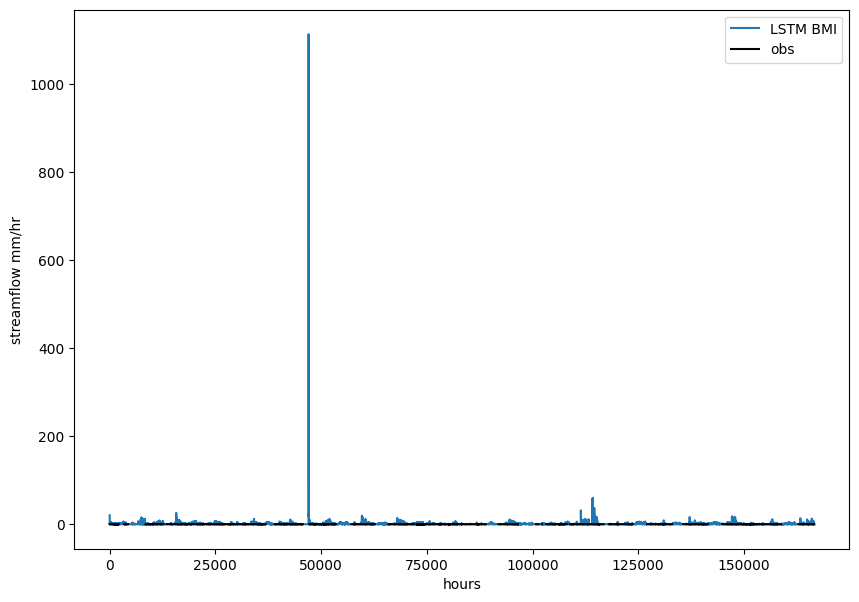

NSE: nan


In [13]:
plt.figure(figsize=(10, 7))
plt.plot(runoff_output, label='LSTM BMI')
plt.plot(obs_df['QObs(mm/h)'], label='obs', c='k')
# plt.ylim([0,0.5])
plt.ylabel('streamflow mm/hr')
plt.xlabel('hours')
plt.legend()
plt.show()
plt.close()

# Calculate a metric
obs = np.array(obs_df['QObs(mm/h)'])
obs = obs
sim = runoff_output
### sim = np.array(runoff_output_list_limited)
denominator = ((obs - obs.mean())**2).sum()
numerator = ((sim - obs)**2).sum()
value = 1 - numerator / denominator
print("NSE: {:.2f}".format(1 - numerator / denominator))

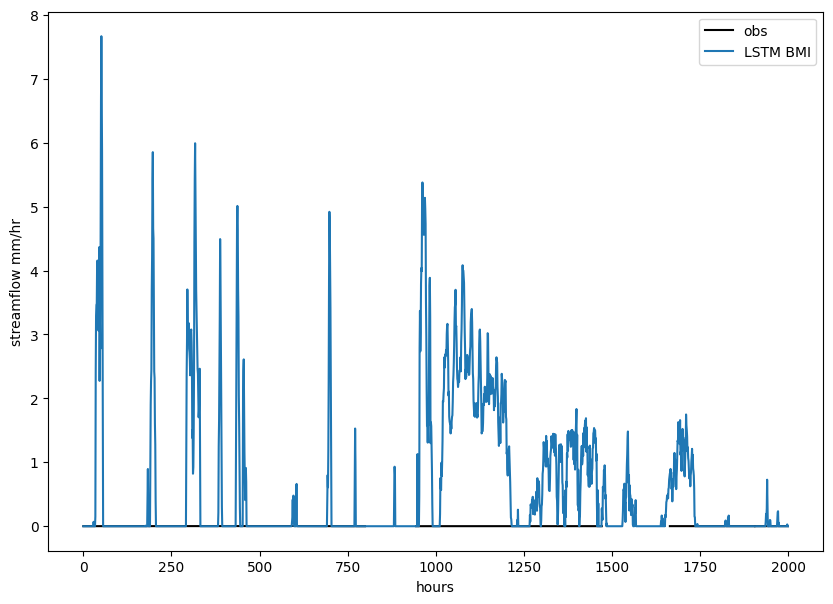

NSE: nan


In [15]:
plt.figure(figsize=(10, 7))
plt.plot(obs[25000:27000], label='obs', c='k')
plt.plot(runoff_output[25000:27000], label='LSTM BMI')
#plt.ylim([0,0.5])
plt.ylabel('streamflow mm/hr')
plt.xlabel('hours')
plt.legend()
plt.show()
plt.close()

### sim = np.array(runoff_output_list_limited)
denominator = ((obs[25000:27000] - obs[25000:27000].mean())**2).sum()
numerator = ((sim[25000:27000] - obs[25000:27000])**2).sum()
value = 1 - numerator / denominator
print("NSE: {:.2f}".format(1 - numerator / denominator))

0